In [1]:
#Imports
import sys
sys.path.append("../")
import numpy
import os
import matplotlib
from tensorflow import keras
from classes import ModelWrapper, DataLoader, Cluster, Plotting

#Interactive matplotlib plots
%matplotlib widget

2024-04-12 09:54:29.284059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Initialisation
experimental = True

modelAPI = ModelWrapper(keras.models.load_model("../models/3D/small"), "base",0.3)
#modelAPI = ModelWrapper.loadPostprocessed("../models/3D/ensemble_lessdeep", "base")
track_type = "alltracks"
data_loader = DataLoader("../data")
noisy = data_loader.getBatch(experimental, True, track_type=track_type, normalising=True)[:1000]
noisy_with_E = data_loader.getBatch(experimental, True, track_type=track_type, normalising=False)[:1000]
clean = data_loader.getBatch(experimental,False, track_type=track_type)
classified = modelAPI.classify( modelAPI.evaluateBatch(noisy) )
names = data_loader.getX17Names(track_type)

2024-04-12 09:54:31.395497: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


32/32 [==============================] - 5s 157ms/step


In [4]:
#Find all and good clusters numbers
NN_all = 0
NN_good = 0
nonNN_all = 0
nonNN_good = 0

for i in range(classified.shape[0]):
	for cluster in Cluster.clusterise(clean[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		print(cluster.tests)
		if cluster.isGood():	nonNN_good += 1
		nonNN_all += 1

	for cluster in Cluster.clusterise(classified[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	NN_good += 1
		NN_all += 1

print("# nonNN clusters:", nonNN_all)
print("# nonNN good clusters:", nonNN_good)
print("# NN clusters:", NN_all)
print("# NN good clusters:", NN_good)
print("")
print("nonNN relative precision:", nonNN_good / nonNN_all)
print("NN relative precision:", NN_good / NN_all)

{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': False, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': False, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': False, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': False, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': True, 'neighbours': True, 'energy_density': True}
{'length': True, 'zone': False, 'neighbours': True, 'energy_density': True}
{'length': True, 'zo

Traceback (most recent call last):
  File "/home/gajdoma6/anaconda3/envs/UTEF_ML/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_9823/3479311676.py", line 8, in <module>
    for cluster in Cluster.clusterise(clean[i]):
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gajdoma6/UTEF/track_denoiser/notebooks/../classes.py", line -1, in clusterise
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/gajdoma6/anaconda3/envs/UTEF_ML/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gajdoma6/anaconda3/envs/UTEF_ML/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.str

In [4]:
#Fragmentation analysis
NN_all = 0
NN_good = []
nonNN_all = 0
nonNN_good = []
NN_fragmentation_number = 0
nonNN_fragmentation_number = 0

for i in range(classified.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)
	
	NN_fragmentation_number += len(clusters_NN) - len(clusters_NN_defrag)
	nonNN_fragmentation_number += len(clusters_nonNN) - len(clusters_nonNN_defrag)

	for cluster in clusters_nonNN_defrag:
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	nonNN_good.append(i)
		nonNN_all += 1

	for cluster in clusters_NN_defrag:
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	NN_good.append(i)
		NN_all += 1

print("# nonNN clusters after defragmentation:", nonNN_all)
print("# nonNN good clusters after defragmentation:", len(nonNN_good))
print("# NN clusters after defragmentation:", NN_all)
print("# NN good clusters after defragmentation:", len(NN_good))
print("")
print("nonNN relative precision:", len(nonNN_good) / nonNN_all)
print("NN relative precision:", len(NN_good) / NN_all)
print("")
print("nonNN fragmentation number:", nonNN_fragmentation_number)
print("NN fragmentation number:", NN_fragmentation_number)

# nonNN clusters after defragmentation: 736
# nonNN good clusters after defragmentation: 348
# NN clusters after defragmentation: 648
# NN good clusters after defragmentation: 344

nonNN relative precision: 0.47282608695652173
NN relative precision: 0.5308641975308642

nonNN fragmentation number: 79
NN fragmentation number: 12


NN bad nonNN good: 20
NN good nonNN bad: 28
L: 46 , N_coef: 4.434782608695652 , tests: {'length': True, 'zone': True, 'neighbours': False, 'energy_density': True}
L: 5 , N_coef: 2.6 , tests: {'length': False, 'zone': True, 'neighbours': True, 'energy_density': True}


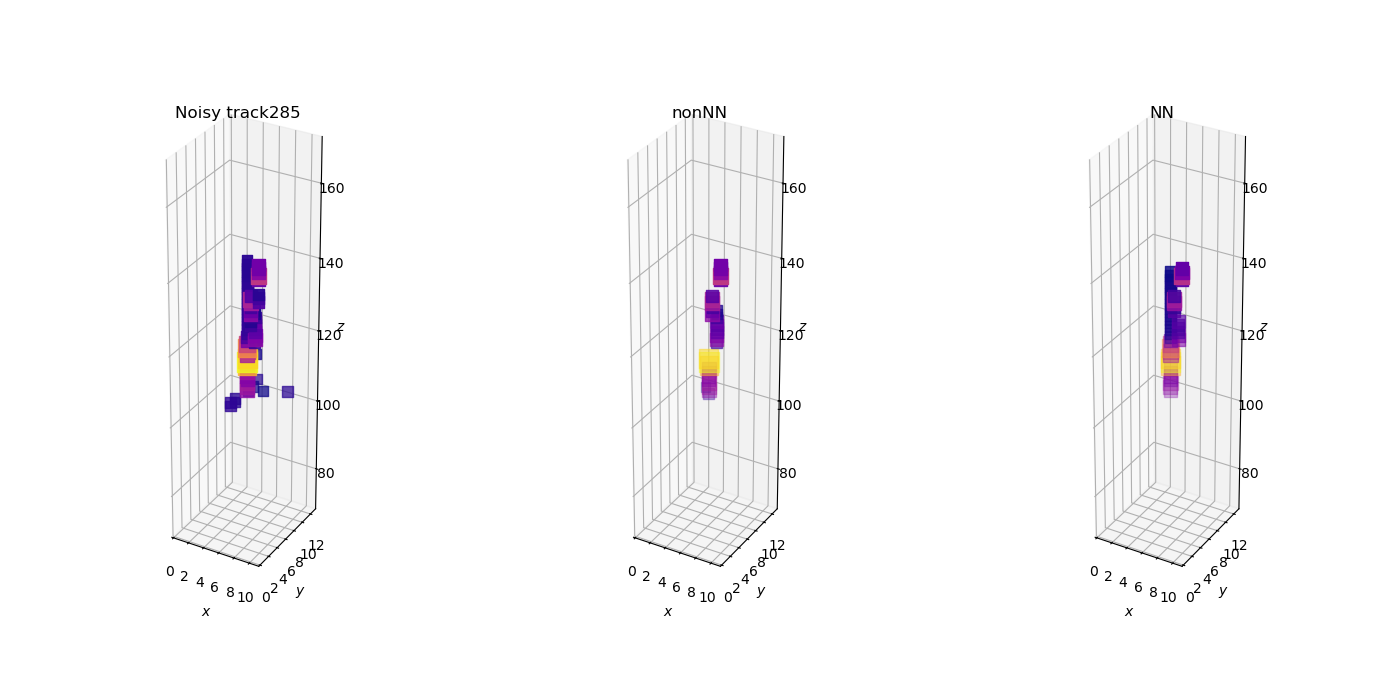

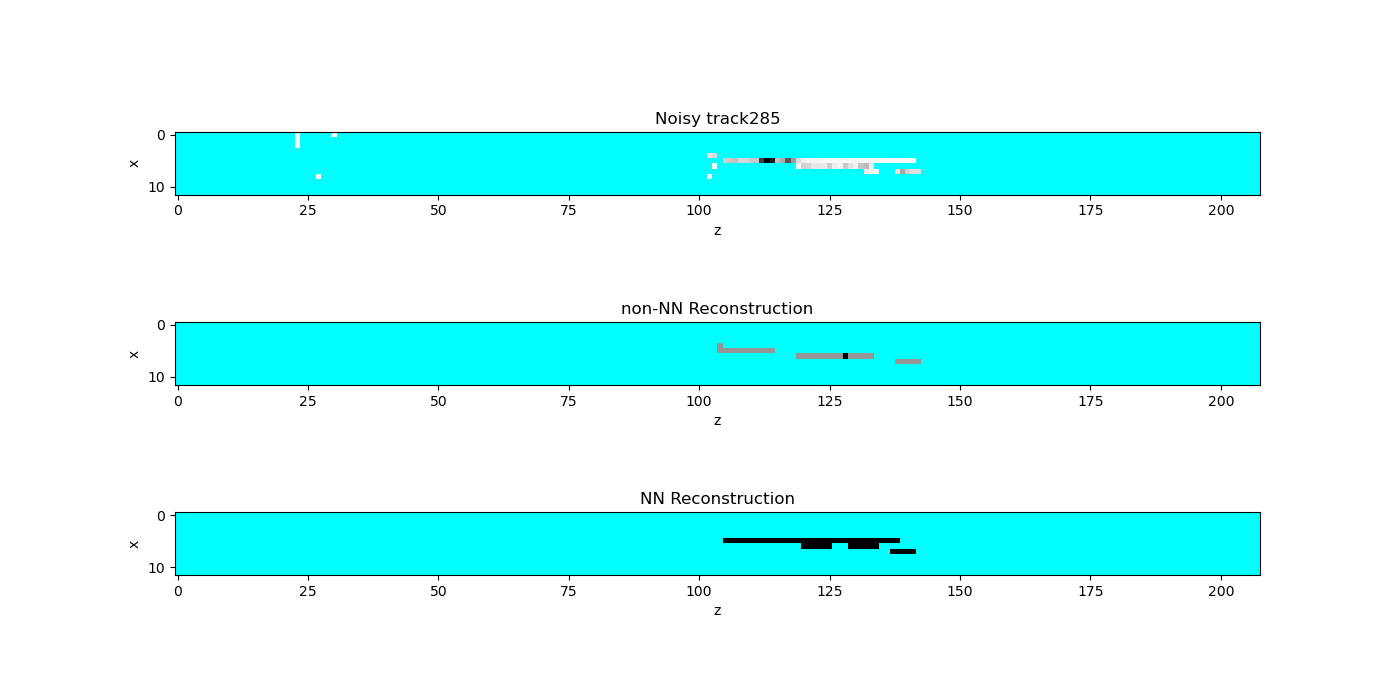

In [7]:
#Show good nonNN bad NN
diff = [i for i in nonNN_good if i not in NN_good]
other_diff = [i for i in NN_good if i not in nonNN_good]
index = numpy.random.choice(diff)
print("NN bad nonNN good:",len(diff))
print("NN good nonNN bad:", len(other_diff))

for cluster in Cluster.clusterise(classified[index]):
	cluster.setEnergy(noisy_with_E[index])
	cluster.runTests()
	print("L:", cluster.length, ", N_coef:", cluster.neighbour_coef, ", tests:", cluster.tests)

fig = matplotlib.pyplot.figure(figsize=matplotlib.pyplot.figaspect(0.33))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
Plotting.plot3DToAxis(noisy[index], ax1, "Noisy " + names[index], z_cut = (70,170))
Plotting.plot3DToAxis(clean[index], ax2, "nonNN", z_cut = (70,170))
E_max = numpy.max(noisy_with_E[index])

Plotting.plot3DToAxis(numpy.where(classified[index]>0, noisy[index],0), ax3, "NN", z_cut = (70,170))

fig.set_size_inches(14, 7)
fig.tight_layout()

Plotting.getPlotEventOneAxis(noisy[index], numpy.where(clean[index]>0,1,0), classified[index], 1, names[index])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 7)


In [21]:
#Show fragmented
def areDuplicities(xs):
	duplicity_dict = {}
	for x in xs:
		if x in duplicity_dict:	return True
		duplicity_dict[x] = True
	return False

duplicities = []
for i in range(classified.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	connections1, connections2 = Cluster.crossconnectClusters(clusters_nonNN, clusters_NN)
	if areDuplicities(connections1):	duplicities.append((i,False))
	if areDuplicities(connections2):	duplicities.append((i,True))

nonNN Fragmented


[]

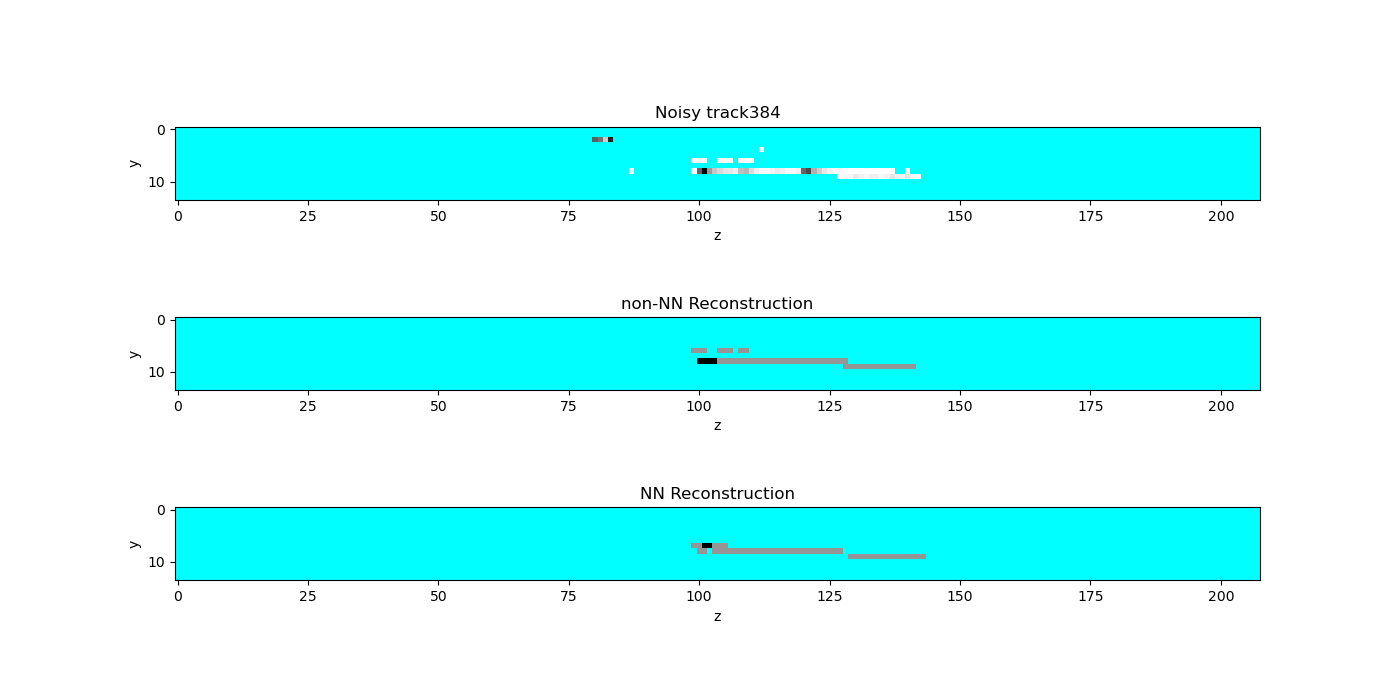

In [8]:
axis = 0

index, is_NN = numpy.random.default_rng().choice(duplicities)
if is_NN:	print("NN Fragmented")
else:	print("nonNN Fragmented")
Plotting.getPlotEventOneAxis(noisy[index], numpy.where(clean[index]>0,1,0), classified[index], axis, names[index])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 7)
matplotlib.pyplot.plot()

In [6]:
#Compare all models numbers
#Find all and good clusters numbers
good_c = 0
all_c = 0

for i in range(clean.shape[0]):
	for cluster in Cluster.clusterise(clean[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	good_c += 1
		all_c += 1

print("------------------")
print("nonNN all:", all_c)
print("nonNN good:", good_c)
print("nonNN relative precision:", good_c / all_c)
print("------------------")

for name in os.listdir("../models/3D/"):
	print(name)
	modelAPI = ModelWrapper.loadPostprocessed("../models/3D/" + name, name)
	temp_classified = modelAPI.classify( modelAPI.evaluateBatch(noisy) )
	
	good_c = 0
	all_c = 0
	for i in range(temp_classified.shape[0]):
		for cluster in Cluster.clusterise(temp_classified[i]):
			cluster.setEnergy(noisy_with_E[i])
			cluster.runTests()
			if cluster.isGood():	good_c += 1
			all_c += 1
	print("all:", all_c, "good:", good_c, "relative precision:", good_c / all_c)

------------------
nonNN all: 815
nonNN good: 377
nonNN relative precision: 0.4625766871165644
------------------
base+noise_shortcuts
21/21 [==============================] - 6s 253ms/step
all: 1397 good: 228 relative precision: 0.1632068718682892
waveform_spatial_series_compress_30epochs
21/21 [==============================] - 4s 201ms/step
all: 640 good: 296 relative precision: 0.4625
waveform_spatial_series_compress_80epochs
21/21 [==============================] - 4s 201ms/step
all: 908 good: 362 relative precision: 0.3986784140969163
paralel3
21/21 [==============================] - 6s 260ms/step
all: 619 good: 270 relative precision: 0.43618739903069464
waveform_spatial_series_compress
21/21 [==============================] - 4s 195ms/step
all: 636 good: 308 relative precision: 0.48427672955974843
small
21/21 [==============================] - 3s 163ms/step
all: 743 good: 359 relative precision: 0.4831763122476447
3_blocks
21/21 [==============================] - 6s 264ms/step


In [6]:
#Get specific model all and good clusters numbers
name = "waveforms_spatial_separate"	#PROMISING: ITERATIVE_4, ITERATIVE_6, waveform_spatial_series_compress, expand_and_compress_1x1x1
good_c = 0
all_c = 0
modelAPI = ModelWrapper.loadPostprocessed("../models/3D/" + name, name)

#inputs = keras.layers.Input((12,14,208))
#modelAPI.model = keras.Model(inputs = inputs, outputs = modelAPI.model(modelAPI.model(modelAPI.model(inputs))))
temp_classified = modelAPI.classify( modelAPI.evaluateBatch(noisy) )

for i in range(temp_classified.shape[0]):
	for cluster in Cluster.clusterise(temp_classified[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	good_c += 1
		all_c += 1
print(name + " all:", all_c, "good:", good_c, "relative precision:", good_c / all_c)

21/21 [==============================] - 3s 139ms/step
waveforms_spatial_separate all: 779 good: 264 relative precision: 0.33889602053915274


In [ ]:
#Numbers for set plot - clusters
counter = 0
for event in noisy:
	counter += len(Cluster.clusterise((event)))
print("All clusters:", counter)

table = {
	"NN":	{
		"fragmented":	{
			"all": 0,
			"good": []	},
		"defragmented":	{
			"all":	0,
			"good":	[]	},
		},
	"nonNN":	{
		"fragmented":	{
			"all": 0,
			"good": []	},
		"defragmented":	{
			"all":	0,
			"good":	[]	},
		}
	}

lone = {
	"NN":	{
		"all": 0,
		"good": 0
	},
	"nonNN":	{
		"all": 0,
		"good": 0
	}
}

def evaluate(cluster, E_event):
	cluster.setEnergy(E_event)
	cluster.runTests()
	return cluster.isGood()

for i in range(clean.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)

	table["NN"]["fragmented"]["all"] += len(clusters_NN)
	table["NN"]["defragmented"]["all"] += len(clusters_NN_defrag)
	table["nonNN"]["fragmented"]["all"] += len(clusters_nonNN)
	table["nonNN"]["defragmented"]["all"] += len(clusters_nonNN_defrag)

	for cluster in clusters_NN:	table["NN"]["fragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_nonNN:	table["nonNN"]["fragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_NN_defrag:	table["NN"]["defragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_nonNN_defrag:	table["nonNN"]["defragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []

	nonNN_subset_of_NN, NN_subset_of_nonNN = Cluster.crossconnectClusters(clusters_nonNN, clusters_NN)
	nonNN_are_disconnected = [True]*len(clusters_nonNN)
	NN_are_disconnected = [True]*len(clusters_NN)
	for j in range( len(nonNN_subset_of_NN) ):
		if nonNN_subset_of_NN[j] != None:
			NN_are_disconnected[ nonNN_subset_of_NN[j] ] = False
			nonNN_are_disconnected[j] = False
	for j in range( len(NN_subset_of_nonNN) ):
		if NN_subset_of_nonNN[j] != None:
			nonNN_are_disconnected[ NN_subset_of_nonNN[j] ] = False
			NN_are_disconnected[j] = False
	
	for j in range( len(nonNN_are_disconnected) ):
		if nonNN_are_disconnected[j]:
			lone["nonNN"]["all"] += 1
			if evaluate(clusters_nonNN[j], noisy_with_E[i]):	lone["nonNN"]["good"] += 1
	for j in range( len(NN_are_disconnected) ):
		if NN_are_disconnected[j]:
			lone["NN"]["all"] += 1
			if evaluate(clusters_NN[j], noisy_with_E[i]):	lone["NN"]["good"] += 1

	'''for j in range( len(NN_subset_of_nonNN) ):	
		if NN_subset_of_nonNN[j] == None:
			lone["NN"]["all"] += 1
			if evaluate(clusters_NN[j], noisy_with_E[i]):	lone["NN"]["good"] += 1'''

print("BEFORE DEFRAGMENTATION:")
print("All nonNN:", table["nonNN"]["fragmented"]["all"])
print("All NN:", table["NN"]["fragmented"]["all"])
print("Good nonNN:", len(table["nonNN"]["fragmented"]["good"]))
print("Good NN:", len(table["NN"]["fragmented"]["good"]))

print("--------------------------------")

print("AFTER DEFRAGMENTATION:")
print("All nonNN:", table["nonNN"]["defragmented"]["all"])
print("All NN:", table["NN"]["defragmented"]["all"])
print("Good nonNN:", len(table["nonNN"]["defragmented"]["good"]))
print("Good NN:", len(table["NN"]["defragmented"]["good"]))

print("--------------------------------")

print("Lone nonNN:", lone["nonNN"]["all"])
print("Lone NN:", lone["NN"]["all"])
print("Lone good nonNN:", lone["nonNN"]["good"])
print("Lone good NN:", lone["NN"]["good"])

In [4]:
#Numbers for set plot - events
counter = 0

print("All:", noisy.shape[0])

table = {
	"NN":	{
		"fragmented":	{
			"all": 0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		},
		"defragmented":	{
			"all":	0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		}
	},
	"nonNN":	{
		"fragmented":	{
			"all": 0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		},
		"defragmented":	{
			"all":	0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		}
	}
}

def evaluate(cluster, E_event):
	cluster.setEnergy(E_event)
	cluster.runTests()
	return cluster.isGood()

for i in range(clean.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)

	truth_good_nonNN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_nonNN]
	truth_good_NN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_NN]
	truth_good_defrag_nonNN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_nonNN_defrag]
	truth_good_defrag_NN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_NN_defrag]

	table["NN"]["fragmented"]["good"]["any"] += [i] if any(truth_good_NN) else []
	table["NN"]["fragmented"]["good"]["all"] += [i] if len(truth_good_NN) != 0 and all(truth_good_NN) else []
	table["NN"]["defragmented"]["good"]["any"] += [i] if any(truth_good_defrag_NN) else []
	table["NN"]["defragmented"]["good"]["all"] += [i] if len(truth_good_defrag_NN) != 0 and all(truth_good_defrag_NN) else []
	table["nonNN"]["fragmented"]["good"]["any"] += [i] if any(truth_good_nonNN) else []
	table["nonNN"]["fragmented"]["good"]["all"] += [i] if len(truth_good_nonNN) != 0 and all(truth_good_nonNN) else []
	table["nonNN"]["defragmented"]["good"]["any"] += [i] if any(truth_good_defrag_nonNN) else []
	table["nonNN"]["defragmented"]["good"]["all"] += [i] if len(truth_good_defrag_nonNN) != 0 and all(truth_good_defrag_nonNN) else []


print("BEFORE DEFRAGMENTATION:")
print("At least one good nonNN:", len(table["nonNN"]["fragmented"]["good"]["any"]))
print("All good nonNN:", len(table["nonNN"]["fragmented"]["good"]["all"]))
print("At least one good NN:", len(table["NN"]["fragmented"]["good"]["any"]))
print("All good NN:", len(table["NN"]["fragmented"]["good"]["all"]))

print("At least one good nonNN no good NN:", len([i for i in table["nonNN"]["fragmented"]["good"]["any"] if i not in table["NN"]["fragmented"]["good"]["any"]]))
print("At least one good NN no good nonNN:", len([i for i in table["NN"]["fragmented"]["good"]["any"] if i not in table["nonNN"]["fragmented"]["good"]["any"]]))

print("--------------------------------")

print("AFTER DEFRAGMENTATION:")
print("At least one good nonNN:", len(table["nonNN"]["defragmented"]["good"]["any"]))
print("All good nonNN:", len(table["nonNN"]["defragmented"]["good"]["all"]))
print("At least one good NN:", len(table["NN"]["defragmented"]["good"]["any"]))
print("All good NN:", len(table["NN"]["defragmented"]["good"]["all"]))

print("At least one good nonNN no good NN:", len([i for i in table["nonNN"]["defragmented"]["good"]["any"] if i not in table["NN"]["defragmented"]["good"]["any"]]))
print("At least one good NN no good nonNN:", len([i for i in table["NN"]["defragmented"]["good"]["any"] if i not in table["nonNN"]["defragmented"]["good"]["any"]]))


All: 641
BEFORE DEFRAGMENTATION:
At least one good nonNN: 250
All good nonNN: 95
At least one good NN: 267
All good NN: 123
At least one good nonNN no good NN: 12
At least one good NN no good nonNN: 29
--------------------------------
AFTER DEFRAGMENTATION:
At least one good nonNN: 250
All good nonNN: 107
At least one good NN: 267
All good NN: 126
At least one good nonNN no good NN: 11
At least one good NN no good nonNN: 28


In [ ]:
print( [names[i] for i in table["NN"]["defragmented"]["good"]["any"] if i not in table["nonNN"]["defragmented"]["good"]["any"]])

Good nonNN:
384, 516, 74, 115, 326, 105, 98, 364, 340, 37, 312, 14, 208, 239, 415, 566, 143, 235, 283, 300, 375, 474, 621, 161, 58, 51, 28, 269, 433, 641, 462, 327, 373, 142, 15, 492, 350, 600, 628, 630, 144, 145, 140, 88, 299, 586, 266, 504, 30, 422, 136, 601, 301, 337, 569, 588, 211, 279, 631, 629, 68, 207, 493, 116, 308, 160, 278, 29, 623, 273, 163, 330, 3, 255, 254, 237, 556, 93, 398, 79, 597, 203, 470, 73, 9, 580, 233, 573, 356, 100, 178, 635, 97, 509, 119, 21, 546, 465, 260, 107, 7, 409, 540, 151, 306, 432, 577, 331, 249, 92, 558, 47, 627, 304, 440, 19, 585, 524, 228, 598, 218, 531, 506, 542, 342, 483, 298, 103, 285, 175, 201, 159, 234, 109, 195, 608, 438, 461, 246, 609, 345, 615, 170, 44, 252, 13, 469, 570, 523, 26, 292, 197, 307, 8, 35, 590, 447, 1, 84, 508, 467, 275, 57, 282, 263, 303, 491, 626, 33, 333, 61, 640, 94, 425, 99, 317, 512, 131, 155, 390, 636, 385, 253, 582, 532, 591, 348, 238, 555, 459, 449, 610, 288, 455, 169, 16, 277, 171, 513, 616, 624, 484, 60, 518, 397, 399, 487, 185, 401, 374, 319, 236, 637, 410, 494, 86, 223, 625, 250, 214, 611, 17, 153, 176, 383, 204, 224, 104, 404, 541, 617, 226, 271, 562, 179, 502, 217, 435, 193, 520, 592, 102, 322, 613, 500, 599, 63, 291, 215, 426, 405


Good NN:
384, 516, 74, 529, 115, 326, 105, 98, 364, 340, 341, 37, 312, 14, 208, 424, 239, 415, 566, 143, 235, 283, 300, 375, 474, 311, 161, 58, 51, 28, 269, 433, 641, 462, 327, 142, 15, 492, 350, 202, 600, 628, 630, 96, 144, 45, 145, 140, 88, 299, 12, 125, 504, 30, 422, 136, 601, 301, 337, 569, 588, 279, 631, 629, 68, 207, 493, 360, 308, 160, 278, 29, 623, 273, 163, 330, 334, 3, 255, 456, 237, 556, 93, 398, 79, 597, 470, 73, 580, 233, 100, 178, 635, 97, 258, 509, 152, 119, 395, 21, 546, 572, 465, 260, 107, 7, 409, 540, 151, 306, 432, 577, 331, 249, 622, 92, 558, 47, 627, 304, 440, 19, 524, 228, 598, 218, 531, 506, 542, 342, 483, 298, 103, 285, 175, 612, 201, 159, 370, 109, 608, 461, 246, 609, 345, 615, 170, 44, 252, 13, 469, 570, 523, 26, 197, 307, 8, 35, 590, 164, 447, 467, 57, 282, 263, 303, 491, 33, 333, 61, 640, 94, 425, 99, 317, 512, 155, 390, 636, 385, 582, 532, 591, 348, 238, 555, 459, 610, 437, 288, 455, 169, 16, 277, 171, 513, 616, 624, 484, 60, 518, 397, 399, 487, 401, 319, 236, 637, 410, 494, 86, 223, 625, 214, 611, 17, 153, 176, 204, 224, 104, 404, 541, 617, 271, 562, 179, 502, 217, 435, 193, 322, 613, 500, 599, 63, 291, 215, 405

Good nonNN bad NN:
621, 373, 586, 266, 211, 116, 254, 203, 9, 573, 356, 585, 234, 195, 438, 292, 1, 84, 508, 275, 626, 131, 253, 449, 185, 374, 250, 383, 226, 520, 592, 102, 426

Good NN bad nonNN:
529, 341, 424, 311, 202, 96, 45, 12, 125, 360, 334, 456, 258, 152, 395, 572, 622, 612, 370, 164, 437

